## Makeplot for HTML Monitor for Environmental Overview

plotting data used for the backscatter correction (Hurst et al., 2014)

requires observations of monobeams and Sagnac signal for the ring under investigation to be in place

## Imports

In [1]:
import os
os.environ['MPLCONFIGDIR'] = '/tmp/mplconfig_cache'

import gc
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read
from scipy.signal import hilbert

In [2]:
from functions.load_backscatter_data import __load_backscatter_data
from functions.find_max_min import __find_max_min
from functions.backscatter_correction import __backscatter_correction

In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/ontap-ffb-bay200/'
    lamont_path = '/home/andbro/lamont/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'
elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'

## Configurations

In [4]:
config = {}

# specify ring for which backscatter is done
config['ring'] = "Z"

# specify length of time interval to show
config['time_interval'] = 2 # days

config['last_reset'] = UTCDateTime("2024-10-01 14:00")

# define time interval
config['tend'] = UTCDateTime().now()
if abs(config['tend'] - config['last_reset']) > config['time_interval']*86400:
    config['tbeg'] = config['tend'] - config['time_interval'] * 86400
else:
    config['tbeg'] = config['last_reset']

# define nominal sagnac frequency of rings
config['ring_sagnac'] = {"U":303.05, "V":447.5, "W":447.5, "Z":553.2}

# select nominal sagnac frequency
config['nominal_sagnac'] = config['ring_sagnac'][config['ring']]

# specify path to the data
config['path_to_data'] = data_path+"sagnac_frequency/data/backscatter/"

# path to figure output
config['path_to_figs'] = data_path+f"HTML_Monitor/figures/"


### Load Archived Backscatter Files

In [5]:
bs = __load_backscatter_data(config['tbeg'], config['tend'], config['ring'], config['path_to_data'])

bs['time_sec'] = bs.time2 - bs.time1 + (bs.time1 - bs.time1.loc[0])

In [6]:
# compute backscatter corrected signal
bs['fj_bs'] = __backscatter_correction(bs.f1_ac / bs.f1_dc,
                                         bs.f2_ac / bs.f2_dc,
                                         np.unwrap(bs.f1_phw) - np.unwrap(bs.f2_phw),
                                         bs.fj_fs,
                                         np.nanmedian(bs.fj_fs),
                                         cm_filter_factor=1.033,
                                         )


## Processing

In [7]:
def __find_max_min(lst, pp=99, perc=0, add_percent=None):

    from numpy import nanpercentile

    maxs, mins = [], []

    for l in lst:
        maxs.append(nanpercentile(l, pp))
        mins.append(nanpercentile(l, 100-pp))

    if perc == 0:
        out_min, out_max = min(mins), max(maxs)
    else:
        _min = min(mins)
        _max = max(maxs)
        xx = _max*(1+perc) - _max
        out_min, out_max = _min-xx, _max+xx

    if add_percent is None:
        return out_min, out_max
    else:
        return out_min-out_min*add_percent, out_max+out_max*add_percent

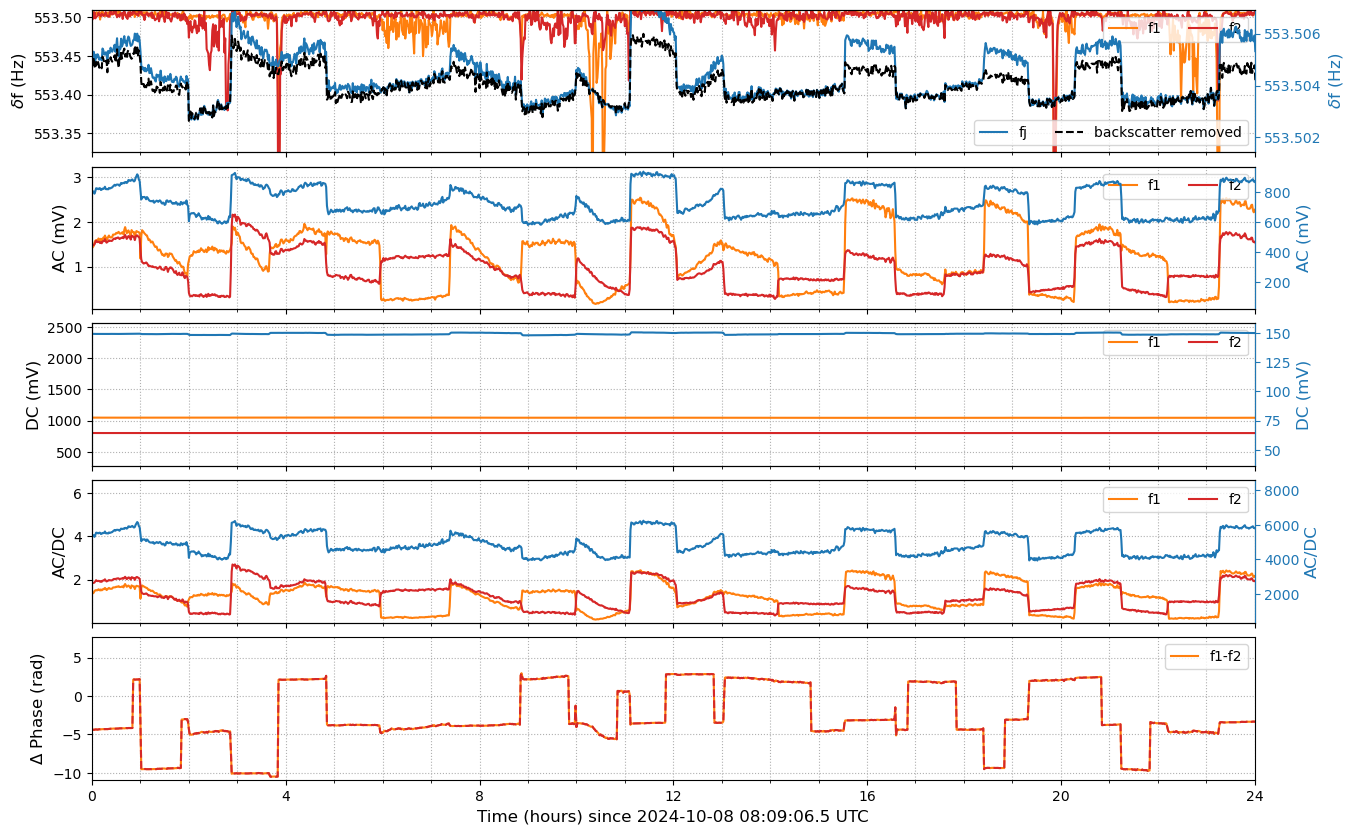

In [14]:
def __makeplot2(df):

    from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

    Nrow, Ncol = 5, 1

    font = 12

    ms = 15

    tscale, tunit = 1/3600, "hours"

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 10), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    t_axis = bs.time_sec * tscale

    ax[0].plot(t_axis, df['f1_fs'], zorder=2, label="f1", color="tab:orange")
    ax[0].plot(t_axis, df['f2_fs'], zorder=2, label="f2", color="tab:red")
    ax[0].set_ylabel("$\delta$f (Hz)", fontsize=font)
    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylim(__find_max_min([df['f1_fs'], df['f2_fs']], pp=98))
    ax[0].legend(loc=1, ncol=2)

    ax00 = ax[0].twinx()
    ax00.plot(t_axis, df['fj_fs'], zorder=2, color="tab:blue", label="fj")
    ax00.plot(t_axis, df['w_s'], zorder=2, ls="--", color="k", label="backscatter removed")
    ax00.set_ylabel("$\delta$f (Hz)", fontsize=font)
    ax00.spines['right'].set_color('tab:blue')
    ax00.yaxis.label.set_color('tab:blue')
    ax00.tick_params(axis='y', colors='tab:blue')
    # ax00.set_yticks(np.linspace(ax00.get_yticks()[0], ax00.get_yticks()[-1], len(ax[0].get_yticks())))
    ax00.ticklabel_format(useOffset=False)
    ax00.set_ylim(__find_max_min([df['fj_fs']], pp=98))
    ax00.legend(loc=4, ncol=2)

    ax[1].plot(t_axis, df['f1_ac']*1e3, zorder=2, label="f1", color="tab:orange")
    ax[1].plot(t_axis, df['f2_ac']*1e3, zorder=2, label="f2", color="tab:red")
    ax[1].set_ylabel("AC (mV)", fontsize=font)
    ax[1].set_ylim(__find_max_min([df['f1_ac']*1e3, df['f2_ac']*1e3], pp=99.5, add_percent=0.05))

    ax11 = ax[1].twinx()
    ax11.plot(t_axis, df['fj_ac']*1e3, zorder=2, label="fj")
    ax11.set_ylabel("AC (mV)", fontsize=font)
    ax11.spines['right'].set_color('tab:blue')
    ax11.yaxis.label.set_color('tab:blue')
    ax11.tick_params(axis='y', colors='tab:blue')
    # ax11.set_yticks(np.linspace(ax11.get_yticks()[0], ax11.get_yticks()[-1], len(ax[1].get_yticks())))
    ax11.set_ylim(__find_max_min([df['fj_ac']*1e3], pp=99.5, add_percent=0.05))

    ax[2].plot(t_axis, df['f1_dc']*1e3, zorder=2, label="f1", color="tab:orange")
    ax[2].plot(t_axis, df['f2_dc']*1e3, zorder=2, label="f2", color="tab:red")
    ax[2].set_ylabel("DC (mV)", fontsize=font)
    ax[2].set_ylim(__find_max_min([df['f1_dc']*1e3, df['f2_dc']*1e3], pp=99.5, add_percent=0.05))

    ax21 = ax[2].twinx()
    ax21.plot(t_axis, df['fj_dc']*1e3, zorder=2, label="fj")
    ax21.set_ylabel("DC (mV)", fontsize=font)
    ax21.spines['right'].set_color('tab:blue')
    ax21.yaxis.label.set_color('tab:blue')
    ax21.tick_params(axis='y', colors='tab:blue')
    # ax21.set_yticks(np.linspace(ax21.get_yticks()[0], ax21.get_yticks()[-1], len(ax[2].get_yticks())))
    ax21.set_ylim(__find_max_min([df['fj_dc']*1e3], pp=99.5, add_percent=0.05))

    ax[3].plot(t_axis, df['f1_ac']/df['f1_dc']*1e3, zorder=2, label="f1", color="tab:orange")
    ax[3].plot(t_axis, df['f2_ac']/df['f2_dc']*1e3, zorder=2, label="f2", color="tab:red")
    ax[3].set_ylabel("AC/DC", fontsize=font)
    # ax[3].set_ylim(0, 8e-3)
    ax[3].set_ylim(__find_max_min([df['f1_ac']/df['f1_dc']*1e3, df['f2_ac']/df['f2_dc']*1e3], pp=99.9))

    ax31 = ax[3].twinx()
    ax31.plot(t_axis, df['fj_ac']/df['fj_dc']*1e3, zorder=2, label="fj")
    ax31.set_ylabel("AC/DC", fontsize=font)
    ax31.spines['right'].set_color('tab:blue')
    ax31.yaxis.label.set_color('tab:blue')
    ax31.tick_params(axis='y', colors='tab:blue')
    # ax31.set_yticks(np.linspace(ax31.get_yticks()[0], ax31.get_yticks()[-1], len(ax[3].get_yticks())))
    ax31.set_ylim(__find_max_min([df['fj_ac']/df['fj_dc']*1e3], pp=99.5, add_percent=0.05))

    ax[4].plot(t_axis, df['f1_ph']-df['f2_ph'], color="tab:orange", zorder=2, label="f1-f2")
    ax[4].plot(t_axis, df['f1_ph']-df['f2_ph'], color="tab:red", zorder=2, ls="--")
    ax[4].set_ylabel("$\Delta$ Phase (rad)", fontsize=font)
    ax[4].set_ylim(__find_max_min([df['f1_ph']-df['f2_ph']], pp=99.5, add_percent=0.05))

    for i in range(Nrow):
        ax[i].set_xlim(0, 24)
        ax[i].xaxis.set_major_locator(MultipleLocator(4))
        ax[i].xaxis.set_minor_locator(MultipleLocator(1))

    ax[4].set_xlabel(f"Time ({tunit}) since {config['tbeg'].date} {str(config['tbeg'].time)[:10]} UTC", fontsize=font)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0, which="both")
        ax[_n].legend(loc=1, ncol=3)

    plt.show();
    return fig

fig = __makeplot2(bs);

fig.savefig(config['path_to_figs']+f"html_backscatter.png", format="png", dpi=150, bbox_inches='tight')
